In [1]:
import time
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

import xgboost as xgb
from catboost import CatBoostClassifier

from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.feature_extraction import FeatureHasher
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif

# Helper Functions

### Function Return Indecies of Null Records in a Dataframe

In [2]:
def get_null_rec_idx(df):   return df.isnull().any(axis=1)

### Function Reports Unqiue Values of Passed Columns to the Dataframe & Their counts

In [3]:
def report_unique_values_count(data, columns=None):
    if columns is None: columns = data.columns
    for col in columns:
        print(col, data[col].value_counts(), ", Unique Values Count:", data[col].nunique())

### Function Plots Kernel Density Estimation (Distribution) & their Skewness for the Passed Columns of the Dataframe

In [4]:
def show_features_skewness(data, columns=None, plot_grid_cols=4):
    if columns is None: columns = data.columns

    plot_grid_rows = int(np.ceil(len(columns) / plot_grid_cols))
    fig, axes = plt.subplots(plot_grid_rows, plot_grid_cols, figsize=(20, 20), sharex=False)


    for i, column in enumerate(columns):
        row, col = divmod(i, plot_grid_rows)

        sns.kdeplot(data[column], ax=axes[row, col])
        skewness = data[column].skew()
        axes[row, col].text(
            x=0.97, y=0.97, transform=axes[row, col].transAxes,
            s=f'Skewness: {skewness}',
            fontweight='demibold', fontsize=12, verticalalignment='top',
            horizontalalignment='right', backgroundcolor='white',
            color='xkcd:poo brown'
        )
        
    for i in range(len(columns), plot_grid_rows * plot_grid_cols):
        fig.delaxes(axes.ravel()[i])

    plt.tight_layout()
    plt.show()


### Function Takes this Specific Dataset & Returns:
Target Column, Binary Columns, Numeric Columns & Categorical Columns Names based on the data analysis done in the notebook

In [5]:
def categorise_data_columns(data):
    target_column, binary_columns = 'Target Attack', ['subdomain']
    numeric_columns = list(set(data.select_dtypes(include=['int64', 'float64']).columns) - set([target_column] + binary_columns))
    categorical_columns = list(set(data.select_dtypes(include=['object', 'bool']).columns) - set(numeric_columns + binary_columns + [target_column]))
    return target_column, binary_columns, numeric_columns, categorical_columns

### Function That Apply Required Data Preprocessing Steps on the Dataframe to prepare it for Normalization & Modeling
Dropping Nulls<br>
Transforming Timestamp to standard measuring unit fraction of seconds<br>
Split features & target<br>
Hash Encoding sld & longest_word categorical features into passed number of hash components (defualt: 16)<br>
& returns preprocessed features, & names of target, binary(0 or 1), numeric & hashed categorical columns

In [6]:
def preprocess_data(data, n_hash_components = 2**4):

    # Define the hashing transformer
    hasher = FeatureHasher(n_features=n_hash_components, input_type='string')
    data_copy = data.copy()
    # Drop null values
    data_copy.dropna(inplace=True)
    data_copy.reset_index(drop=True, inplace=True)

    # Transform timestamp into aggregated form of it's components
    timestamp_pattern = r'(\d+):(\d+)\.(\d+)'
    timestamp_components = pd.DataFrame(data_copy['timestamp'].str.extract(timestamp_pattern).values.tolist(), index=data_copy.index, columns=['min', 'sec', 'sec_frac'])
    data_copy['timestamp'] = timestamp_components['min'].astype('Int64') * 60 * 10 + timestamp_components['sec'].astype('Int64') * 10 + timestamp_components['sec_frac'].astype('Int64')
    
    # Prepare Different Categories of Columns
    target_column, binary_columns, numeric_columns, categorical_columns = categorise_data_columns(data_copy)
    hash_columns=[f'hash_comp_{i}' for i in range(n_hash_components)]

    #split data into X & y
    y = data_copy[target_column]
    X = data_copy.drop(target_column, axis=1)

    # Prepare Categorical Columns for Hashing
        # Create column combined_cat that combine both values of the two categorical values of same record in single list to prepare it for hashing
    X['combined_cat'] = X[categorical_columns].astype(str).values.tolist()
        # Replace categorical columns with hashed columns
    X.drop(categorical_columns, axis=1, inplace=True)
    
    # Hash Categorical Columns
    hash_comp = hasher.transform(X['combined_cat'])
    # Save Them to DataFrame
    hash_comp = pd.DataFrame(hash_comp.toarray(), columns=hash_columns)
    # Drop combined_cat column
    X.drop('combined_cat', axis=1, inplace=True)

    # Combine Hashed Columns with X
    X_preprocessed = pd.concat([X, hash_comp], axis=1)
    
    return X_preprocessed, y, target_column, binary_columns, numeric_columns, hash_columns


### Function Splits Data into train, validation, test sets with based on passed portion of data for validation & test sets (default 0.15)

In [7]:
def split_data_train_val_test(X, y, val_size=0.15, test_size=0.15, random_state=777):
    
    #split preprocess_images_df into train, validation, test sets with 70% : 15% : 15% protions for train : validation : test sets
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size= val_size + test_size, random_state=random_state, stratify=y)
    #split traindata into validation, test sets with 50% : 50% protions for validation : test sets
    val_X, test_X, val_y, test_y = train_test_split(test_X, test_y, test_size= test_size / (val_size + test_size), random_state=random_state, stratify=test_y)
    # rest indices
    train_X, train_y, val_X, val_y, test_X, test_y = train_X.reset_index(drop=True), train_y.reset_index(drop=True), val_X.reset_index(drop=True), val_y.reset_index(drop=True), test_X.reset_index(drop=True), test_y.reset_index(drop=True)

    # show the size of each set
    print(f"Training set size: {len(train_X)}")
    print(f"Validation set size: {len(val_X)}")
    print(f"Testing set size: {len(test_X)}")
   
    return train_X, train_y, val_X, val_y, test_X, test_y

### Function Applies Select Best K Features for all Possible Ks & Plot their Resulted Performance on Baseline Model Based on Passed:
Features Dataframe & Target Series, a Model (Default: Baseline XGBoost) & Feature Filtering Score Function (Default: ANOVA F-Value)


In [8]:
def show_model_f1_with_all_bestK_features(X, y, model=xgb.XGBClassifier(seed=777), score_func=f_classif,):
    #Split X_train and y_train into train & validation sets 80:20 ratio stratified sampling
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=777)

    f1_scores, Ks = [], [ k for k in range(1, X.shape[1] + 1)]
    # Define the Best K Features pipeline
    k_best_pipeline = Pipeline([
    ('select_k_best', SelectKBest(score_func=score_func)),
    ('model', model)
    ])

    # itertae over different values of K
    for k in Ks:
        # Define the anova trials pipeline
        k_best_pipeline.set_params(select_k_best__k=k)
        # Fit the pipeline
        k_best_pipeline.fit(X_train, y_train)
        # Predict the validation set
        y_pred = k_best_pipeline.predict(X_val)
        # Calculate the model F1-score
        f1_result = f1_score(y_val, y_pred, average='macro')
        # Save f1-score
        f1_scores.append(f1_result)
    
    # Max f1-score Line
    max_score, max_score_k = np.max(f1_scores), Ks[np.argmax(f1_scores)]
    
    # Plot the F1 scores
    plt.figure(figsize=(15, 8))
    plt.plot(Ks, f1_scores, marker='o', label='Testing Set')
    plt.xticks(Ks)        
        
    # Annotate max score
    annotation = plt.annotate(f'{max_score:.4f}', (np.argmax(f1_scores), max_score), textcoords="offset pixels", xytext=(-5, 10), ha='center', color='orange')
    annotation.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'), path_effects.Normal()])

    # Max score lines
    plt.axhline(max_score, linestyle="--", color='orange', label='Max Score')
    plt.axvline(max_score_k, linestyle="--", color='lightblue', label='K of Max Score')

    plt.xlabel('K')
    plt.ylabel('F1 Score')
    plt.title('F1 Score over Best K Features')
    plt.legend()

### Function Compares & Plot Performance of two XGBoost Models Trained on Best K Features Selected by ANOVA F-Value & Mutual Information Score
Based on Passed Features Dataframe & Target Series & K Features for ANOVA F-Value Score Model (Default: 23) & Mutual Info Score Model (Default: 29)

In [9]:
def compare_feature_filtering_models(X, y, anova_k=23, mi_k=29):
    #Split X_train and y_train into train & validation sets 80:20 ratio stratified sampling
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=777)
    
    # Define the Anova feature selection pipeline
    anova_pipeline = Pipeline([
        ('anova', SelectKBest(f_classif, k=anova_k)),
        ('xgb', xgb.XGBClassifier(random_state=777))
    ])
    
    # Define the Mutual Info feature selection pipeline
    mi_pipeline = Pipeline([
        ('mi', SelectKBest(mutual_info_classif, k=mi_k)),
        ('xgb', xgb.XGBClassifier(random_state=777))
    ])
    
    # Fit the Anova pipeline and calculate the F1 score
    anova_pipeline.fit(X_train, y_train)
    anova_f1_score = f1_score(y_val, anova_pipeline.predict(X_val), average='macro')
    
    # Fit the Mutual Info pipeline and calculate the F1 score
    mi_pipeline.fit(X_train, y_train)
    mi_f1_score = f1_score(y_val, mi_pipeline.predict(X_val), average='macro')
    
    # Print the F1 scores
    print(f"Anova F1 Score: {anova_f1_score:.4f}")
    print(f"Mutual Info F1 Score: {mi_f1_score:.4f}")

    #Show F1-scores comparison
    plt.figure(figsize=(8, 6))
    plt.bar(['ANOVA', 'Mutual Info'], [anova_f1_score, mi_f1_score], color=['lightblue', 'lightgreen'])
    plt.ylabel('f1-score')
    plt.title('Model Performance Comparison on Test Data')
    plt.ylim([min([anova_f1_score, mi_f1_score]) - 0.01, max([anova_f1_score, mi_f1_score]) + 0.01])

    # Annotate the bars with their respective f1-score values
    for i, v in enumerate([anova_f1_score, mi_f1_score]):
        plt.text(i, v, f'{v:.5f}', ha='center', va='bottom', fontsize=12)

    # return Anova Columns & Mutual Info Columns from support
    return np.array(X.columns)[anova_pipeline.named_steps['anova'].get_support()].tolist(), np.array(X.columns)[mi_pipeline.named_steps['mi'].get_support()].tolist()


# Load Data

In [10]:
# read .csv files by names traindata & testdata to pandas dataframes
data = pd.read_csv("Static_dataset.csv")
print(data.shape)

(268074, 16)


# 1 Data Analysis

In [11]:
data.head()

,timestamp,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain,Target Attack
0,56:19.8,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1,1
1,07:23.9,27,10,0,10,11,2.767195,6,6,7,3.666667,2,192,14,1,1
2,23:15.1,26,9,0,10,10,2.742338,6,6,7,3.500000,2,192,13,1,0
3,04:51.9,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1,1
4,12:44.0,15,9,0,11,0,2.929439,4,3,5,4.333333,local,local,15,1,1


In [12]:
data.sample(5)

,timestamp,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain,Target Attack
254444,06:57.2,10,0,0,8,0,1.857542,2,3,4,2.666667,pv,rgpv,5,0,0
77410,37:16.6,24,7,0,10,8,2.054029,6,6,7,3.166667,4,224,11,1,1
44163,00:30.2,25,8,0,10,9,2.556642,6,6,7,3.333333,2,192,12,1,0
136385,10:17.5,26,9,0,10,10,2.742338,6,6,7,3.500000,2,192,13,1,1
87928,22:12.4,24,7,0,10,8,2.054029,6,6,7,3.166667,4,224,11,1,1


In [13]:
data.tail(5)

,timestamp,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain,Target Attack
268069,33:51.5,18,3,0,16,0,2.338623,2,3,10,5.333333,alma,almaalomah,14,1,0
268070,36:02.5,27,10,0,10,11,2.767195,6,6,7,3.666667,2,192,14,1,0
268071,37:21.5,27,10,0,10,11,2.767195,6,6,7,3.666667,2,192,14,1,1
268072,24:25.1,16,0,0,14,0,3.249687,2,2,13,7.500000,radio,radio-vintage,14,0,0
268073,20:56.1,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1,1


In [14]:
# Basic data summary
print("Data Info:")
print(data.info())

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268074 entries, 0 to 268073
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   timestamp         268074 non-null  object 
 1   FQDN_count        268074 non-null  int64  
 2   subdomain_length  268074 non-null  int64  
 3   upper             268074 non-null  int64  
 4   lower             268074 non-null  int64  
 5   numeric           268074 non-null  int64  
 6   entropy           268074 non-null  float64
 7   special           268074 non-null  int64  
 8   labels            268074 non-null  int64  
 9   labels_max        268074 non-null  int64  
 10  labels_average    268074 non-null  float64
 11  longest_word      268066 non-null  object 
 12  sld               268074 non-null  object 
 13  len               268074 non-null  int64  
 14  subdomain         268074 non-null  int64  
 15  Target Attack     268074 non-null  int64  
dtypes: float6

In [15]:
# get numeric features
numeric_columns = list(data.select_dtypes(include=['int64', 'float64']).columns)
print("Numeric columns:")
print(numeric_columns)

Numeric columns:
['FQDN_count', 'subdomain_length', 'upper', 'lower', 'numeric', 'entropy', 'special', 'labels', 'labels_max', 'labels_average', 'len', 'subdomain', 'Target Attack']


### Features Distribution & Skewness

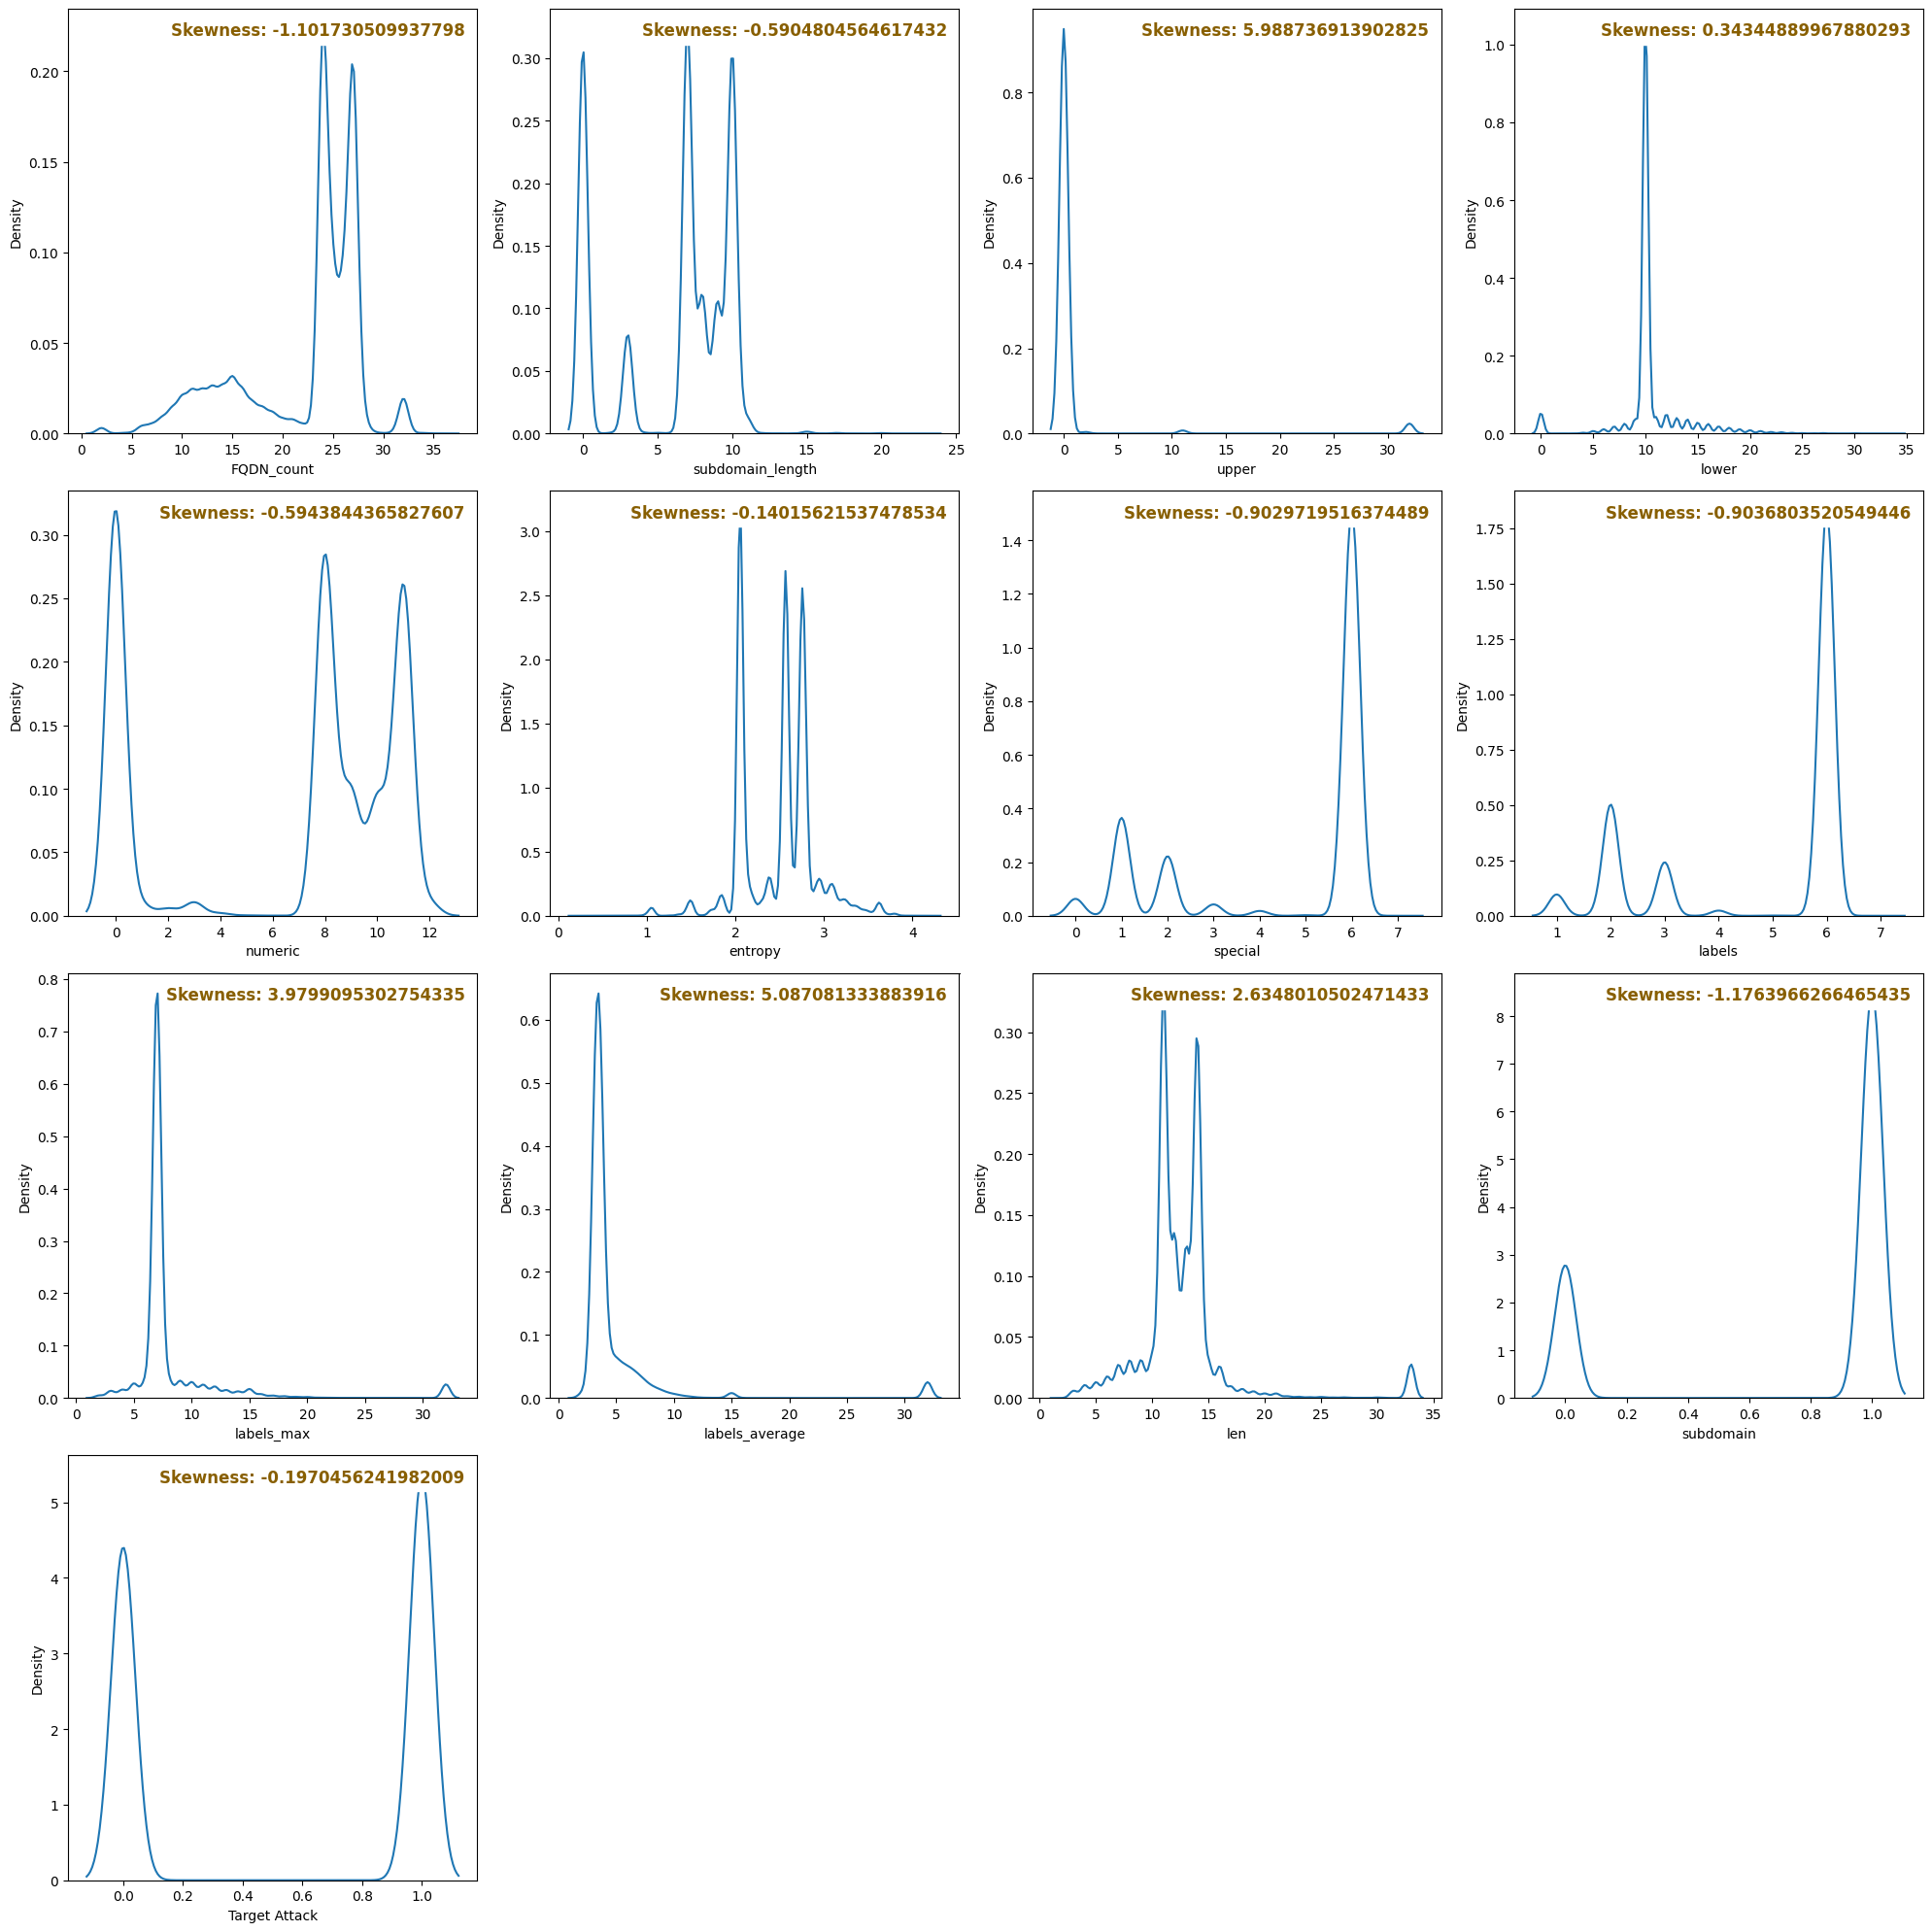

In [16]:
show_features_skewness(data, numeric_columns)

As shown in features distribution & skewness, we can see that most of features are skewed for example:<br>
the features (FQDN_count, special, labels) are negatively skewed & the features (upper, labels_max, labels_average) are positively skewed.

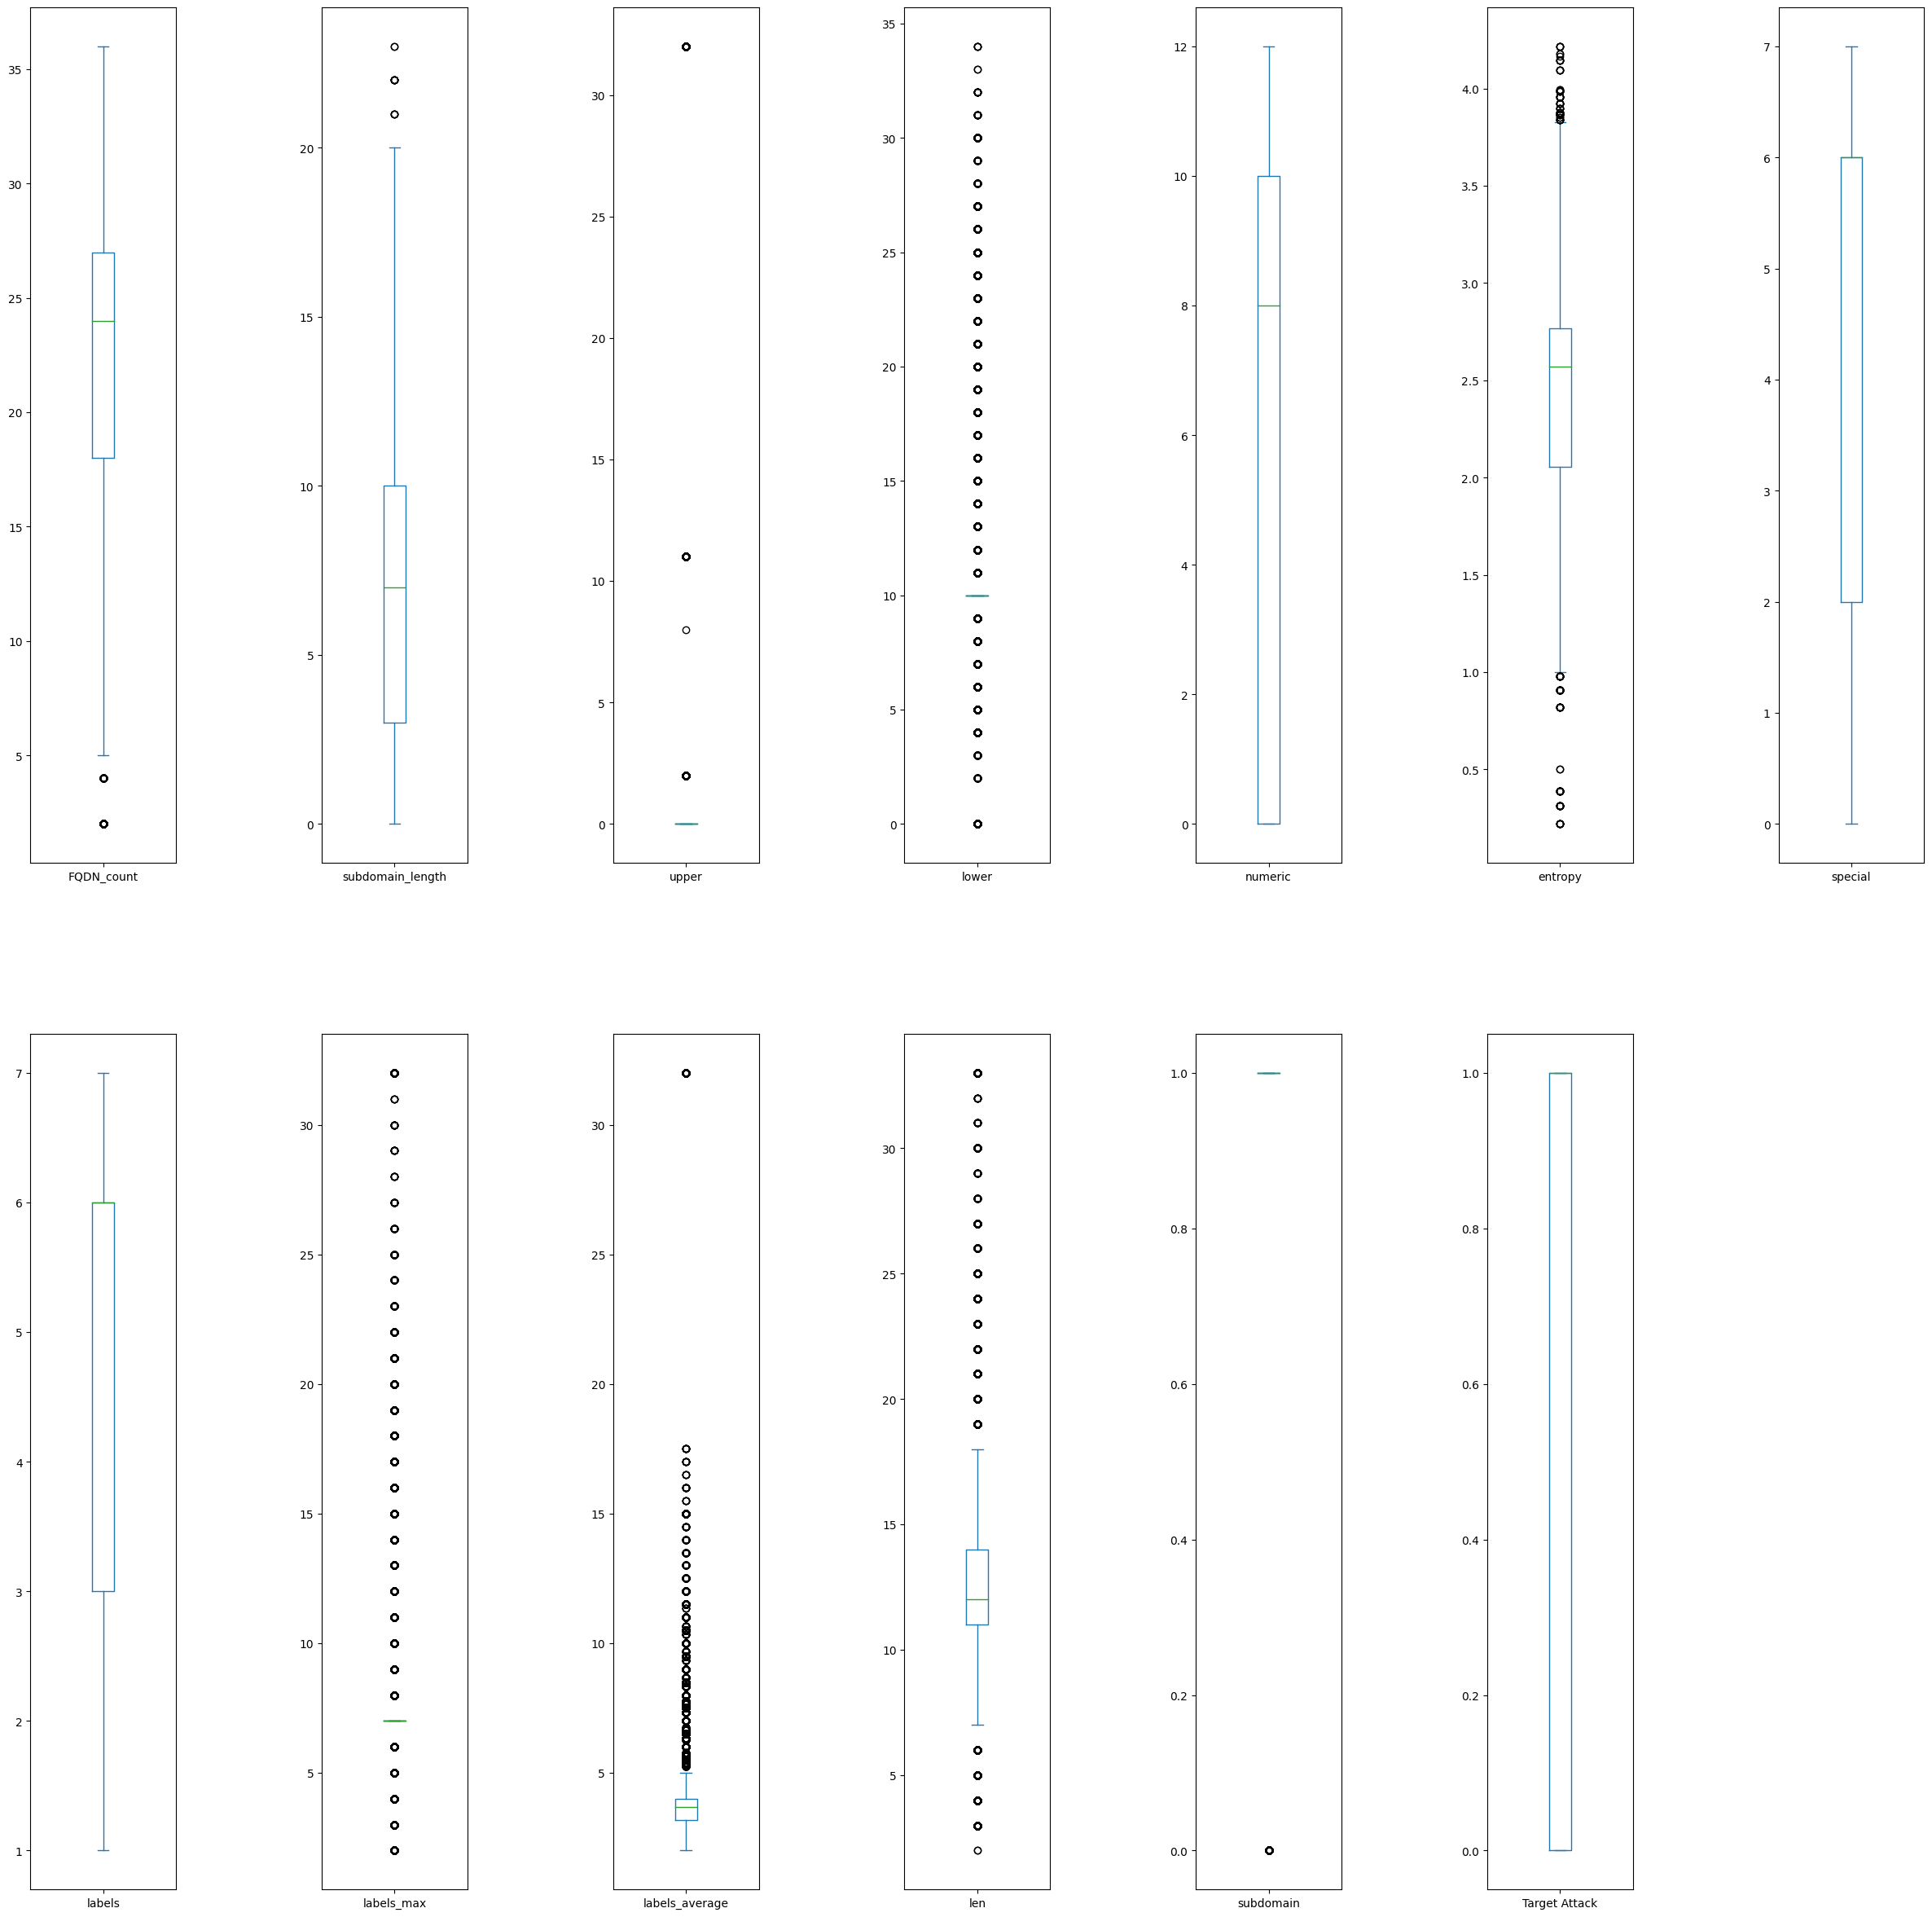

In [17]:
data.plot(kind='box',
             subplots=True,
             layout=(2, 7),
             figsize=(30,30),
             sharey=False)
plt.subplots_adjust(wspace=1)

In [18]:
# Summary statistics
print("\nSummary Statistics:")
data.describe()


Summary Statistics:


,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,len,subdomain,Target Attack
count,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000,268074.000000
mean,22.286596,6.059021,0.845420,10.410014,6.497586,2.485735,4.533577,4.788823,8.252233,4.802239,12.576714,0.753497,0.549024
std,6.001205,3.899505,4.941929,3.207725,4.499866,0.407709,2.187683,1.803256,4.415355,4.573066,4.177828,0.430975,0.497592
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.219195,0.000000,1.000000,2.000000,2.000000,2.000000,0.000000,0.000000
25%,18.000000,3.000000,0.000000,10.000000,0.000000,2.054029,2.000000,3.000000,7.000000,3.166667,11.000000,1.000000,0.000000
50%,24.000000,7.000000,0.000000,10.000000,8.000000,2.570417,6.000000,6.000000,7.000000,3.666667,12.000000,1.000000,1.000000
75%,27.000000,10.000000,0.000000,10.000000,10.000000,2.767195,6.000000,6.000000,7.000000,4.000000,14.000000,1.000000,1.000000
max,36.000000,23.000000,32.000000,34.000000,12.000000,4.216847,7.000000,7.000000,32.000000,32.000000,33.000000,1.000000,1.000000


From the kernal distribution, boxplot & Statistics Summary it seems that the feature (subdomain) is binary categorical feature. we shall confirm that by checking the unique values of this feature.

In [19]:
report_unique_values_count(data, ['subdomain'])

subdomain subdomain
1    201993
0     66081
Name: count, dtype: int64 , Unique Values Count: 2


As shown all values of subdomain are are either 0 or 1, so we can confirm that this feature is binary categorical feature.

### Validate Dataset Imbalance

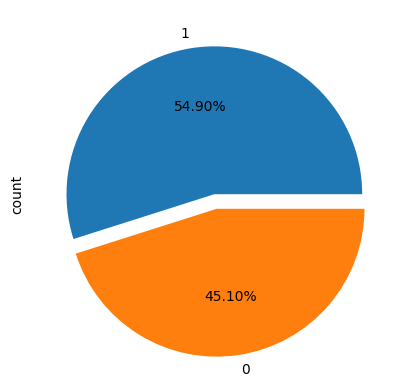

In [20]:
data['Target Attack'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.2f%%');

the Number of Positive samples is more than negative samples, by a little portion of the total samples that is not enough to result data imbalance also it focuses on the targeted class (positve samples)

# 2 Feature engineering & data cleaning

### Check & Handle Missing Values

In [21]:
# Check for missing values
print("\nMissing Values:")
data.isnull().sum()


Missing Values:


timestamp           0
FQDN_count          0
subdomain_length    0
upper               0
lower               0
numeric             0
entropy             0
special             0
labels              0
labels_max          0
labels_average      0
longest_word        8
sld                 0
len                 0
subdomain           0
Target Attack       0
dtype: int64

In [22]:
# show missing records
data[get_null_rec_idx(data)]

,timestamp,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain,Target Attack
45325,16:29.0,9,0,0,8,0,1.820802,1,2,5,4.000000,NaN,nanit,6,0,0
73336,29:00.1,10,0,0,9,0,2.120590,1,2,6,4.500000,NaN,nullpk,7,0,0
105457,49:32.5,13,3,0,11,0,2.067168,2,3,5,3.666667,NaN,nanit,9,1,0
119612,49:32.4,9,0,0,8,0,1.820802,1,2,5,4.000000,NaN,nanit,6,0,0
194276,55:23.2,10,0,0,9,0,2.120590,1,2,6,4.500000,NaN,nullpk,7,0,0
207153,55:23.3,10,0,0,9,0,2.120590,1,2,6,4.500000,NaN,nullpk,7,0,0
233632,29:00.0,10,0,0,9,0,2.120590,1,2,6,4.500000,NaN,nullpk,7,0,0
247640,16:29.2,13,3,0,11,0,2.067168,2,3,5,3.666667,NaN,nanit,9,1,0


Records has Null values are at longest_word feature & also sId feature is set with string value indicates null value. 
Since number of null records is small relative to data size we shall drop it.

In [23]:
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)
# Check for missing values
print("\nMissing Values:")
data.isnull().sum()


Missing Values:


timestamp           0
FQDN_count          0
subdomain_length    0
upper               0
lower               0
numeric             0
entropy             0
special             0
labels              0
labels_max          0
labels_average      0
longest_word        0
sld                 0
len                 0
subdomain           0
Target Attack       0
dtype: int64

### Transform String timestamp Into Model Usage Applicable Features

In [24]:
data[['timestamp']]

,timestamp
0,56:19.8
1,07:23.9
2,23:15.1
3,04:51.9
4,12:44.0
...,...
268061,33:51.5
268062,36:02.5
268063,37:21.5
268064,24:25.1


It seems like timestamp is in time format of (mm:ss.S) where mm is minutes, ss is seconds & S fraction of second. So we shall confirm by checking max & min value of each section of this format.

In [25]:
# Define a regular expression pattern to extract the mm, ss & S values
timestamp_pattern = r'(\d+):(\d+)\.(\d+)'
timestamp_components = pd.DataFrame(data['timestamp'].str.extract(timestamp_pattern).values.tolist(), index=data.index, columns=['min', 'sec', 'sec_frac'])
timestamp_components

,min,sec,sec_frac
0,56,19,8
1,07,23,9
2,23,15,1
3,04,51,9
4,12,44,0
...,...,...,...
268061,33,51,5
268062,36,02,5
268063,37,21,5
268064,24,25,1


In [26]:
# show max & min values of each component
print("Max values:")
print(timestamp_components.max())
print("\nMin values:")
print(timestamp_components.min())

Max values:
min         59
sec         59
sec_frac     9
dtype: object

Min values:
min         00
sec         00
sec_frac     0
dtype: object


As shown the max value of minutes is 59 & max value of seconds is 59 & max value of fraction of second is 9. So we can confirm that the format of timestamp is (mm:ss.S)

#### Transform timestamp into Aggregated form of it's Compnents (minutes, seconds, fraction of second) 
converted into the total number of fraction of seconds to standradize all the values into same unit.

In [27]:
data['timestamp'] = timestamp_components['min'].astype('Int64') * 60 * 10 + timestamp_components['sec'].astype('Int64') * 10 + timestamp_components['sec_frac'].astype('Int64')
data

,timestamp,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain,Target Attack
0,33798,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1,1
1,4439,27,10,0,10,11,2.767195,6,6,7,3.666667,2,192,14,1,1
2,13951,26,9,0,10,10,2.742338,6,6,7,3.500000,2,192,13,1,0
3,2919,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1,1
4,7640,15,9,0,11,0,2.929439,4,3,5,4.333333,local,local,15,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268061,20315,18,3,0,16,0,2.338623,2,3,10,5.333333,alma,almaalomah,14,1,0
268062,21625,27,10,0,10,11,2.767195,6,6,7,3.666667,2,192,14,1,0
268063,22415,27,10,0,10,11,2.767195,6,6,7,3.666667,2,192,14,1,1
268064,14651,16,0,0,14,0,3.249687,2,2,13,7.500000,radio,radio-vintage,14,0,0


In [28]:
data.select_dtypes(include=['int64', 'float64']).columns

Index(['timestamp', 'FQDN_count', 'subdomain_length', 'upper', 'lower',
       'numeric', 'entropy', 'special', 'labels', 'labels_max',
       'labels_average', 'len', 'subdomain', 'Target Attack'],
      dtype='object')

### Categories Features

In [29]:
target_column, binary_columns = 'Target Attack', ['subdomain']
numeric_columns = list(set(data.select_dtypes(include=['int64', 'float64']).columns) - set([target_column] + binary_columns))
categorical_columns = list(set(data.select_dtypes(include=['object', 'bool']).columns) - set(numeric_columns + binary_columns + [target_column]))
print("Numeric columns:")
print(numeric_columns)
print("\nCategorical columns:")
print(categorical_columns)
print("\nBinary columns:")
print(binary_columns)
print("\nAll Columns:")
print(binary_columns + numeric_columns + categorical_columns + [target_column])
print("Lenght:", len(binary_columns + numeric_columns + categorical_columns + [target_column]))

Numeric columns:
['FQDN_count', 'entropy', 'numeric', 'len', 'special', 'labels_max', 'upper', 'labels', 'lower', 'subdomain_length', 'labels_average', 'timestamp']

Categorical columns:
['sld', 'longest_word']

Binary columns:
['subdomain']

All Columns:
['subdomain', 'FQDN_count', 'entropy', 'numeric', 'len', 'special', 'labels_max', 'upper', 'labels', 'lower', 'subdomain_length', 'labels_average', 'timestamp', 'sld', 'longest_word', 'Target Attack']
Lenght: 16


### Split Features from Target

In [30]:
y = data[target_column]
X = data.drop(target_column, axis=1)

### Transform String Categorical Features Into Model Usage Applicable Features

#### Analyze the Unique Values of Each Categorical Feature

In [31]:
report_unique_values_count(X, categorical_columns)

sld sld
192                                 109517
224                                  70188
FHEPFCELEHFCEPFFFACACACACACACABN      4498
DESKTOP-3JF04TC                       1961
239                                   1906
                                     ...  
bukkit                                   1
pc-builds                                1
yaarlnk                                  1
onenote                                  1
queue-it                                 1
Name: count, Length: 11110, dtype: int64 , Unique Values Count: 11110
longest_word longest_word
2          109981
4           70188
N            4498
C            2969
9            1906
            ...  
yaa             1
queue           1
kit             1
airdrop         1
mal             1
Name: count, Length: 6224, dtype: int64 , Unique Values Count: 6224


As shown the number of unique values for each categorical feature is very large (6224 for longest_word & 11110 for sld) So transforming it by one hot encoding will result in very large number of features that will affect the model performance & would be unapplicable, label encoding would result in wrong model performance since it will give the model the impression that the values are ordered especially for sld feature, target encoding would result data leakage & frequency encoding wouldn't be able to be applied incase new unqiue values aroused in test set (same for label encoding).

### Hash Encoding Categorical Features
a good rule of thumb is to use multiple of 2 number of components for hashing trick to avoid collisions. So we shall use 2^4 = 16.

In [32]:
n_components = 2**4 #16
hash_columns=[f'hash_comp_{i}' for i in range(n_components)]
hasher = FeatureHasher(n_features=n_components, input_type='string')

# create column combined_cat that combine both values of the two categorical values of same record in single list to prepare it for hashing
X['combined_cat'] = X[categorical_columns].astype(str).values.tolist()

hashed_features = hasher.transform(X['combined_cat'])
hash_df = pd.DataFrame(hashed_features.toarray(), columns=hash_columns)
hash_result = pd.concat([X[categorical_columns], hash_df], axis=1)
hash_result

,sld,longest_word,hash_comp_0,hash_comp_1,hash_comp_2,hash_comp_3,hash_comp_4,hash_comp_5,hash_comp_6,hash_comp_7,hash_comp_8,hash_comp_9,hash_comp_10,hash_comp_11,hash_comp_12,hash_comp_13,hash_comp_14,hash_comp_15
0,192,2,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,192,2,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,192,2,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,192,2,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,local,local,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268061,almaalomah,alma,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0
268062,192,2,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
268063,192,2,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
268064,radio-vintage,radio,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [33]:
X.drop(categorical_columns + ['combined_cat'], axis=1, inplace=True)
X_hashed = pd.concat([X, hash_df], axis=1)
X_hashed[binary_columns + numeric_columns + hash_columns]

,subdomain,FQDN_count,entropy,numeric,len,special,labels_max,upper,labels,lower,...,hash_comp_6,hash_comp_7,hash_comp_8,hash_comp_9,hash_comp_10,hash_comp_11,hash_comp_12,hash_comp_13,hash_comp_14,hash_comp_15
0,1,27,2.570417,11,14,6,7,0,6,10,...,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,27,2.767195,11,14,6,7,0,6,10,...,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,26,2.742338,10,13,6,7,0,6,10,...,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,27,2.570417,11,14,6,7,0,6,10,...,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,15,2.929439,0,15,4,5,0,3,11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268061,1,18,2.338623,0,14,2,10,0,3,16,...,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0
268062,1,27,2.767195,11,14,6,7,0,6,10,...,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
268063,1,27,2.767195,11,14,6,7,0,6,10,...,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
268064,0,16,3.249687,0,14,2,13,0,2,14,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [34]:
# show added & removed columns from hashing
print("Added columns:")
print(set(X_hashed.columns)-set(X.columns))

Added columns:
{'hash_comp_11', 'hash_comp_7', 'hash_comp_8', 'hash_comp_4', 'hash_comp_6', 'hash_comp_9', 'hash_comp_3', 'hash_comp_12', 'hash_comp_2', 'hash_comp_10', 'hash_comp_0', 'hash_comp_13', 'hash_comp_14', 'hash_comp_15', 'hash_comp_1', 'hash_comp_5'}


#### Test Preprocessing Methode

In [35]:
# read .csv files by names traindata & testdata to pandas dataframes
data = pd.read_csv("Static_dataset.csv")
print(data.shape)

(268074, 16)


In [36]:
X_preprocessed, y, target_column, binary_columns, numeric_columns, hash_columns = preprocess_data(data)
X_preprocessed

,timestamp,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,...,hash_comp_6,hash_comp_7,hash_comp_8,hash_comp_9,hash_comp_10,hash_comp_11,hash_comp_12,hash_comp_13,hash_comp_14,hash_comp_15
0,33798,27,10,0,10,11,2.570417,6,6,7,...,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4439,27,10,0,10,11,2.767195,6,6,7,...,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,13951,26,9,0,10,10,2.742338,6,6,7,...,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2919,27,10,0,10,11,2.570417,6,6,7,...,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7640,15,9,0,11,0,2.929439,4,3,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268061,20315,18,3,0,16,0,2.338623,2,3,10,...,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0
268062,21625,27,10,0,10,11,2.767195,6,6,7,...,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
268063,22415,27,10,0,10,11,2.767195,6,6,7,...,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
268064,14651,16,0,0,14,0,3.249687,2,2,13,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


# 3 Feature Filtering

### Apply Anova Test Feature Filtering

Anova Test Filtering Results:


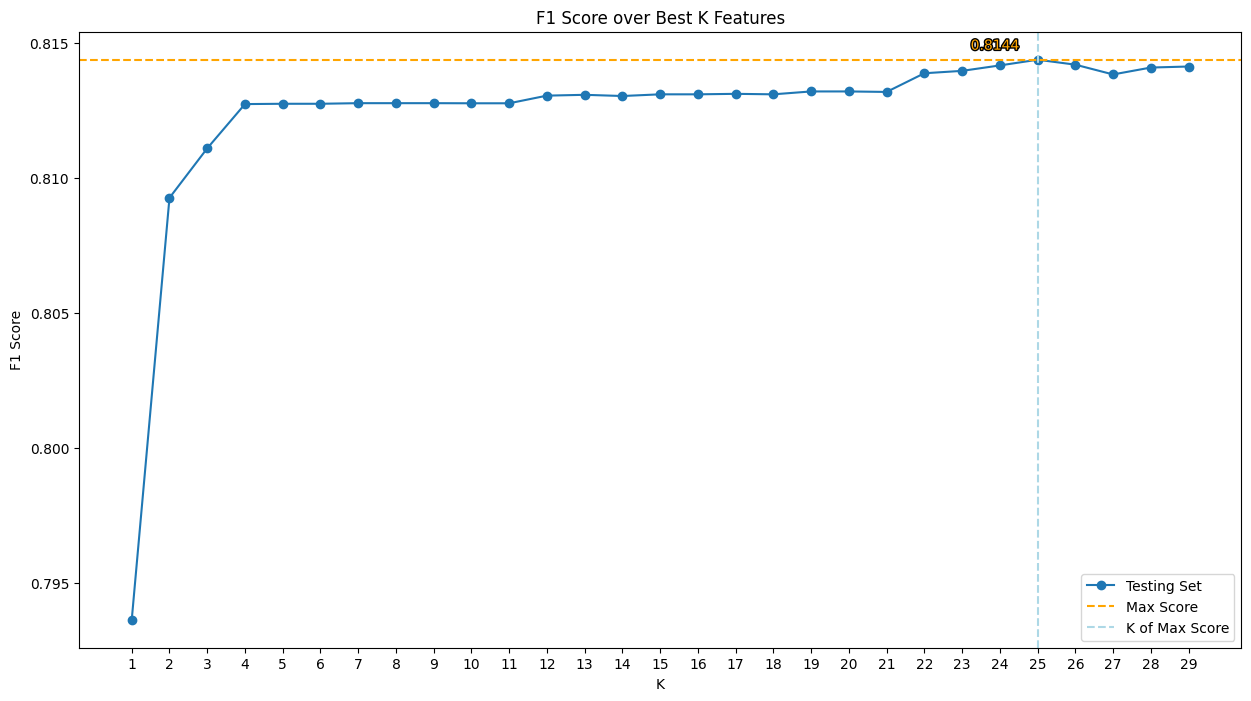

In [37]:
print("Anova Test Filtering Results:")
show_model_f1_with_all_bestK_features(X_preprocessed, y)

#### Anova Test Top K value for Best Number of Features is 23
as it results in the best baseline model performance (f1-score=0.8146)

### Apply Mutual Info Test Feature Filtering

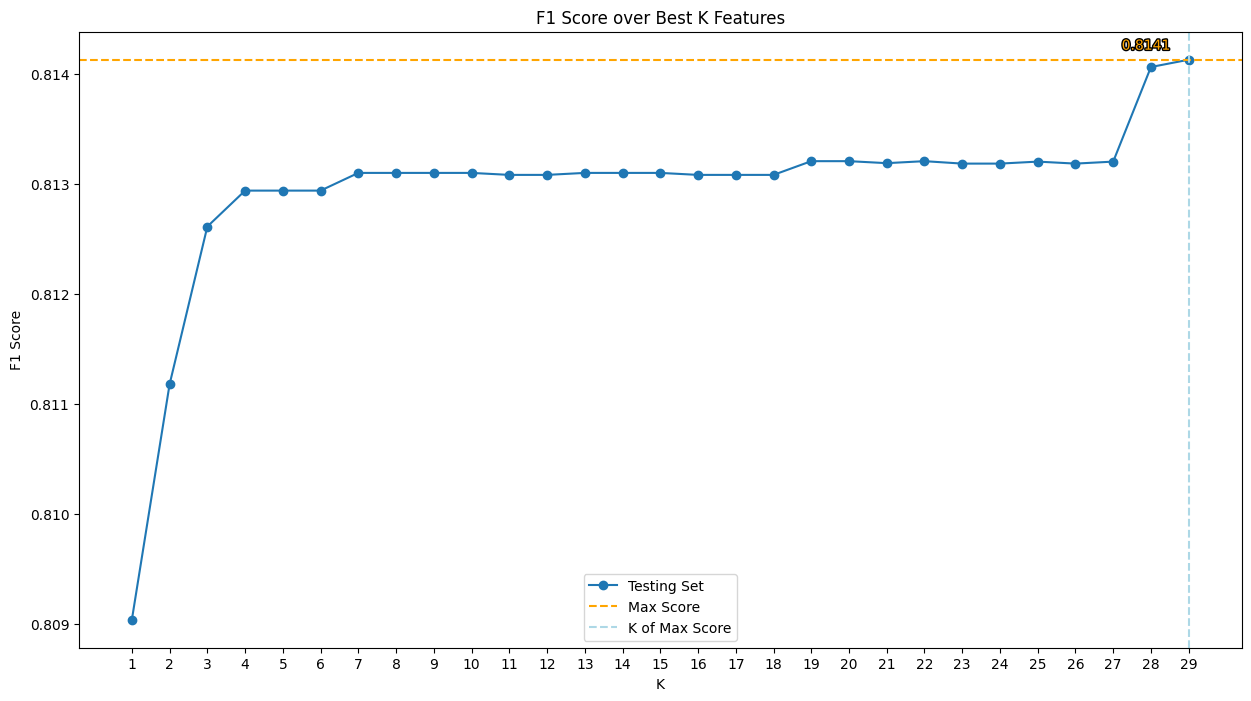

In [38]:
show_model_f1_with_all_bestK_features(X_preprocessed, y, score_func=mutual_info_classif)

#### Mutual Info Top K value for Best Number of Features is 29
as it results in the best baseline model performance (f1-score = 0.8142)

### Compare Top K Feature Filtering Models of Anova & Mutual Info

Anova F1 Score: 0.8140
Mutual Info F1 Score: 0.8141


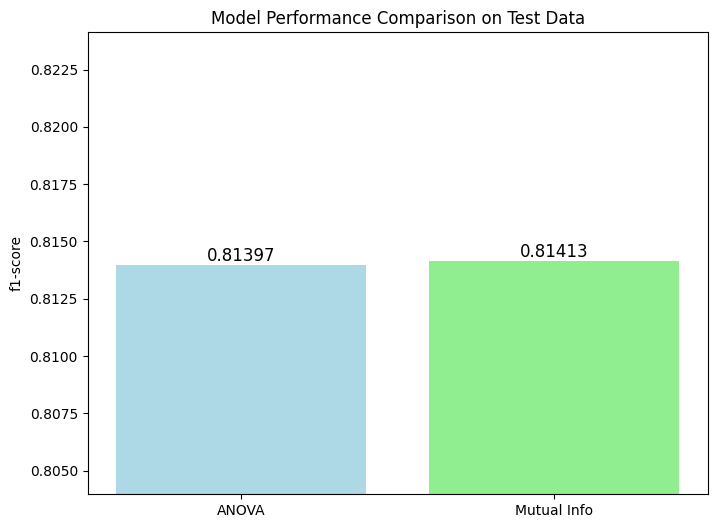

In [39]:
anova_k, mi_k = 23, 29
anova_columns, mi_columns = compare_feature_filtering_models(X_preprocessed, y, anova_k, mi_k)

Since Top K performance of ANOVA baseline is better than Top K performance of Mutual Info baseline, Also with less number of Features we shall use Anova for feature filtering.

#### Top Features List

In [40]:
anova_columns

['timestamp',
 'FQDN_count',
 'subdomain_length',
 'upper',
 'lower',
 'numeric',
 'entropy',
 'special',
 'labels',
 'labels_max',
 'labels_average',
 'len',
 'subdomain',
 'hash_comp_1',
 'hash_comp_4',
 'hash_comp_5',
 'hash_comp_6',
 'hash_comp_7',
 'hash_comp_8',
 'hash_comp_12',
 'hash_comp_13',
 'hash_comp_14',
 'hash_comp_15']

#### Top Features

In [41]:
X_top_features = X_preprocessed[anova_columns]
X_top_features

,timestamp,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,...,hash_comp_1,hash_comp_4,hash_comp_5,hash_comp_6,hash_comp_7,hash_comp_8,hash_comp_12,hash_comp_13,hash_comp_14,hash_comp_15
0,33798,27,10,0,10,11,2.570417,6,6,7,...,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,4439,27,10,0,10,11,2.767195,6,6,7,...,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,13951,26,9,0,10,10,2.742338,6,6,7,...,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2919,27,10,0,10,11,2.570417,6,6,7,...,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,7640,15,9,0,11,0,2.929439,4,3,5,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268061,20315,18,3,0,16,0,2.338623,2,3,10,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0
268062,21625,27,10,0,10,11,2.767195,6,6,7,...,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0
268063,22415,27,10,0,10,11,2.767195,6,6,7,...,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0
268064,14651,16,0,0,14,0,3.249687,2,2,13,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


# 4 Model Training

### Split Data Into Train, Validation & Test Sets
using train_test_split to shuffle the data & split it into Train, Validation & Test Sets. Also we shall use stratify to keep the same ratio of positive & negative samples in all sets.<br>The ratio of Train, Validation & Test Sets is 70%, 15% & 15% respectively So that we can have enough data to train the model & also enough data to validate & test the model.

In [42]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data_train_val_test(X_top_features, y, random_state=777)

Training set size: 187646
Validation set size: 40210
Testing set size: 40210


### Normalize Data through Standardaization

In [43]:
# Define Standard Scaler
standard_scaler = StandardScaler()
X_train_normalized = pd.DataFrame(standard_scaler.fit_transform(X_train), columns=X_train.columns)
X_train_normalized

,timestamp,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,...,hash_comp_1,hash_comp_4,hash_comp_5,hash_comp_6,hash_comp_7,hash_comp_8,hash_comp_12,hash_comp_13,hash_comp_14,hash_comp_15
0,1.425666,1.616578,-1.553553,6.295104,-3.237352,-1.444592,0.614115,-2.071853,-2.101332,5.373965,...,-0.071916,-0.02907,0.057349,0.766263,1.079447,0.546986,-0.008147,0.009801,-0.537909,-4.241964
1,0.794517,-1.046348,-0.784341,-0.171353,1.118174,-1.444592,0.585156,-1.157845,-0.992246,-0.056546,...,-0.071916,-0.02907,-4.487093,0.766263,-0.810507,0.546986,-0.008147,0.009801,-0.537909,4.405845
2,1.557538,-0.879915,-0.784341,-0.171353,1.429283,-1.444592,1.385389,-1.157845,-0.992246,0.169726,...,-0.071916,-0.02907,0.057349,0.766263,-2.700460,0.546986,-0.008147,0.009801,-0.537909,0.081940
3,-1.660906,0.784414,1.010487,-0.171353,-0.126262,1.000272,0.210682,0.670170,0.671382,-0.282817,...,-0.071916,-0.02907,0.057349,-1.120324,1.079447,0.546986,-0.008147,0.009801,-0.537909,0.081940
4,1.671537,-1.545647,-1.553553,-0.171353,0.184847,-1.444592,0.747854,-1.157845,-1.546789,0.169726,...,-0.071916,-0.02907,0.057349,0.766263,-0.810507,0.546986,-5.190640,-5.099083,-0.537909,0.081940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187641,1.455422,0.451548,0.497679,-0.171353,-0.126262,0.555752,0.739233,0.670170,0.671382,-0.282817,...,-0.071916,-0.02907,0.057349,-1.120324,1.079447,0.546986,-0.008147,0.009801,-0.537909,0.081940
187642,0.813839,0.784414,1.010487,-0.171353,-0.126262,1.000272,0.692646,0.670170,0.671382,-0.282817,...,-0.071916,-0.02907,0.057349,-1.120324,1.079447,0.546986,-0.008147,0.009801,-0.537909,0.081940
187643,-1.205200,0.617981,0.754083,-0.171353,-0.126262,0.778012,0.631764,0.670170,0.671382,-0.282817,...,-0.071916,-0.02907,0.057349,-1.120324,1.079447,0.546986,-0.008147,0.009801,-0.537909,0.081940
187644,-0.511931,0.950846,1.266891,-0.171353,-0.126262,1.222533,-0.682397,0.670170,0.671382,-0.282817,...,6.329749,-0.02907,0.057349,0.766263,-0.810507,0.546986,-0.008147,0.009801,-0.537909,0.081940


### Model Training
we shall experiment XGBoost & CatBoost learning algorithms for building Models as they are ensemble models that are effective in Anomely Detection & Classification problems.<br>
Their performance evaluation metric would be f1-score metric although data is balanced to balance the model performance between precision & recall. 

In [44]:
# Define the models
models = {
    'XGBoost': xgb.XGBClassifier(random_state=777),
    'CatBoost': CatBoostClassifier(random_state=777, verbose=False),
}

# Define models pipelines
pipelines = {
    'XGBoost': Pipeline([
        ('xgb', models['XGBoost'])
    ]),
    'CatBoost': Pipeline([
        ('catboost', models['CatBoost'])
    ]),
}

#### Train the Models

In [45]:
trained_models_piplines = {}

for model_name, pipeline in pipelines.items():
    print(f"Training {model_name}...")
    start_time = time.time()
    pipeline.fit(X_train_normalized, y_train)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Time taken: {elapsed_time} seconds")
    trained_models_piplines[model_name] = pipeline    

Training XGBoost...
Time taken: 3.6158289909362793 seconds
Training CatBoost...
Time taken: 14.98250937461853 seconds


#### Normalize Validation Data

In [46]:
X_val_normalized = pd.DataFrame(standard_scaler.transform(X_val), columns=X_val.columns)

#### Evaluate the Models

In [47]:
models_val_f1_scores = {}
for model_name, pipeline in pipelines.items():
    y_pred = pipeline.predict(X_val_normalized)
    f1_result = f1_score(y_val, y_pred, average='macro')
    print(f"{model_name} F1 Score: {f1_result:.4f}")
    models_val_f1_scores[model_name] = f1_result

XGBoost F1 Score: 0.8131
CatBoost F1 Score: 0.8144


#### Plot Validation Performance of the Models

XGBoost F1 Score: 0.8131
CatBoost F1 Score: 0.8144


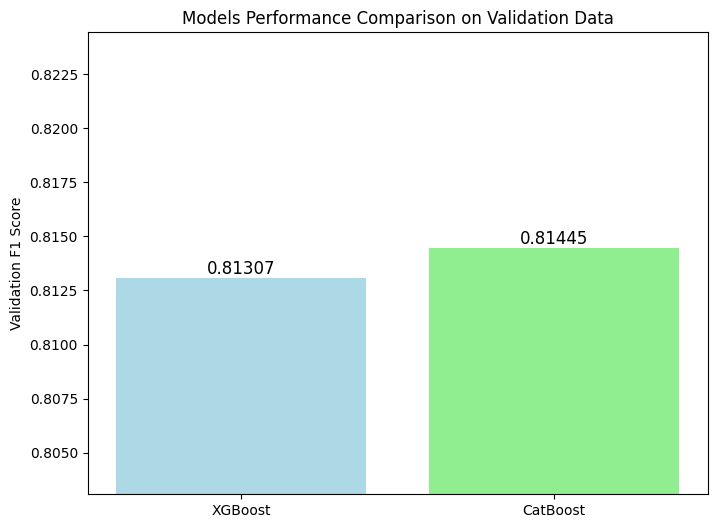

In [48]:
# Print the F1 scores
print(f"XGBoost F1 Score: {models_val_f1_scores['XGBoost']:.4f}")
print(f"CatBoost F1 Score: {models_val_f1_scores['CatBoost']:.4f}")

#Show F1-scores comparison
plt.figure(figsize=(8, 6))
plt.bar(list(models_val_f1_scores), models_val_f1_scores.values(), color=['lightblue', 'lightgreen'])
plt.ylabel('Validation F1 Score')
plt.title('Models Performance Comparison on Validation Data')
plt.ylim([min(models_val_f1_scores.values()) - 0.01, max(models_val_f1_scores.values()) + 0.01])

# Annotate the bars with their respective f1-score values
for i, (_, v) in enumerate(models_val_f1_scores.items()):
    plt.text(i, v, f'{v:.5f}', ha='center', va='bottom', fontsize=12)

As shown the performance of both models are very close to each other, but Catboost model is slightly better than XGBoost model. Eventhough CatBoost Classifier is slower especially in training than XGBoost so we shall use XGBoost Classifier for the sake of speed since there's a slight performance difference.

#### Hyper Parameter Tuning

In [49]:
# Define the XGBoost model
xgb_model = xgb.XGBClassifier(random_state=777)

# Define the hyperparameters grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.03, 0.1, 0.5],
}

# Define the GridSearchCV object
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=1)

# Fit the GridSearchCV object on the training data
grid_search.fit(X_train_normalized, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=777, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.03, 0.1, 0.5],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 200]},
             scoring='f1_macro', verbose=1)

In [50]:
# Get the best parameters and best score
best_params, best_score = grid_search.best_params_, grid_search.best_score_
print("Best Model Parameters:", best_params)
print("Best Model F1-Score On Train Data Cross-Validation:", best_score)

Best Model Parameters: {'learning_rate': 0.5, 'max_depth': 7, 'n_estimators': 100}
Best Model F1-Score On Train Data Cross-Validation: 0.8132905747044733


#### Build, Train & Evaluate Model with Best Parameters On Validation Set

In [51]:
xgb_model_optimized = xgb.XGBClassifier(**best_params, random_state=777)
xgb_model_optimized.fit(X_train_normalized, y_train)
xgb_model_optimized_val_f1_score = f1_score(y_val, xgb_model_optimized.predict(X_val_normalized), average='macro')
print(f"XGBoost Optimized Validation F1 Score: {xgb_model_optimized_val_f1_score:.4f}")

XGBoost Optimized Validation F1 Score: 0.8134


Hyperparameter tuning resulted slight imporvement in the model performance from 0.81307 to 0.8134 f1-score.

# 5 Model Evaluation

### Evaluate the Model on Test Set


#### Normalize Test Data

In [52]:
X_test_normalized = pd.DataFrame(standard_scaler.transform(X_test), columns=X_test.columns)

#### Evaluate the Model

In [53]:
xgb_model_optimized_train_f1_score = f1_score(y_train, xgb_model_optimized.predict(X_train_normalized), average='macro')
xgb_model_optimized_test_f1_score = f1_score(y_test, xgb_model_optimized.predict(X_test_normalized), average='macro')
print(f"XGBoost Optimized Train F1 Score: {xgb_model_optimized_train_f1_score:.4f}")
print(f"XGBoost Optimized Test F1 Score: {xgb_model_optimized_test_f1_score:.4f}")

XGBoost Optimized Train F1 Score: 0.8159
XGBoost Optimized Test F1 Score: 0.8134


### Plot Performance Metrics of the Models

Training F1 Score: 0.815940
Validation F1 Score: 0.813381
Test F1 Score: 0.813430


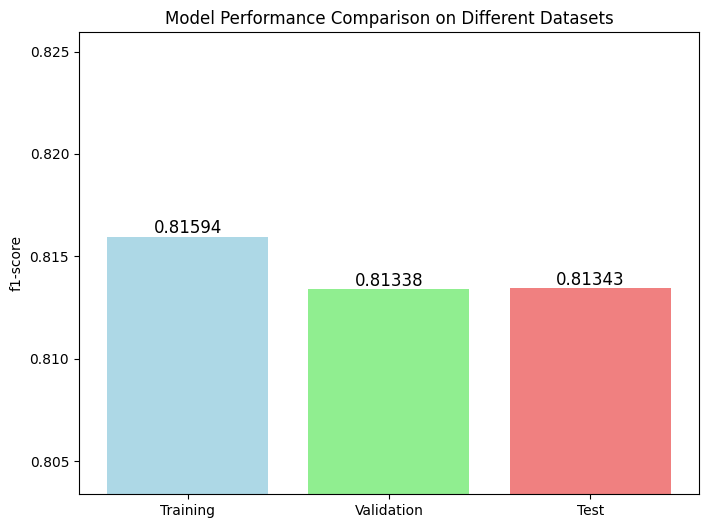

In [54]:
evaluation_sets_f1_scores = {
    'Training': xgb_model_optimized_train_f1_score,
    'Validation': xgb_model_optimized_val_f1_score,
    'Test': xgb_model_optimized_test_f1_score
}

# Print the F1 scores
for dataset, f1_scor in evaluation_sets_f1_scores.items():
    print(f"{dataset} F1 Score: {f1_scor:.6f}")

# Show F1-scores comparison
plt.figure(figsize=(8, 6))
plt.bar(list(evaluation_sets_f1_scores.keys()), evaluation_sets_f1_scores.values(), color=['lightblue', 'lightgreen', 'lightcoral'])
plt.ylabel('f1-score')
plt.title('Model Performance Comparison on Different Datasets')
plt.ylim([min(evaluation_sets_f1_scores.values()) - 0.01, max(evaluation_sets_f1_scores.values()) + 0.01])

# Annotate the bars with their respective f1-score values
for i, (_, v) in enumerate(evaluation_sets_f1_scores.items()):
    plt.text(i, v, f'{v:.5f}', ha='center', va='bottom', fontsize=12)

plt.show()

Model Performance on Train Set is very close to the performance on Validation & Test Sets which is a Good Indication that the Model is less prune to overfitting.

# 6 Model Deployment

#### Split Data Into Train, Validation & Test Sets
but on all preprocessed features & target to test pipeline feature selection.

In [55]:
X_preprocessed.columns

Index(['timestamp', 'FQDN_count', 'subdomain_length', 'upper', 'lower',
       'numeric', 'entropy', 'special', 'labels', 'labels_max',
       'labels_average', 'len', 'subdomain', 'hash_comp_0', 'hash_comp_1',
       'hash_comp_2', 'hash_comp_3', 'hash_comp_4', 'hash_comp_5',
       'hash_comp_6', 'hash_comp_7', 'hash_comp_8', 'hash_comp_9',
       'hash_comp_10', 'hash_comp_11', 'hash_comp_12', 'hash_comp_13',
       'hash_comp_14', 'hash_comp_15'],
      dtype='object')

In [56]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data_train_val_test(X_preprocessed, y, random_state=777)

Training set size: 187646
Validation set size: 40210
Testing set size: 40210


### Build Model Pipeline

In [57]:
best_model_pipeline = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_classif, k=23)),
    ('normalization', StandardScaler()),
    ('model', xgb.XGBClassifier(**best_params, random_state=777))
    ])

best_model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('feature_selection', SelectKBest(k=23)),
                ('normalization', StandardScaler()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.5,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=777, ...))])

### Test Model Pipeline

In [58]:
# Show the best model F1 score
y_pred = best_model_pipeline.predict(X_val)
f1_result = f1_score(y_val, y_pred, average='macro')
print(f"Validation F1 Score: {f1_result:.4f}")

# Show the best model F1 score
y_pred = best_model_pipeline.predict(X_test)
f1_result = f1_score(y_test, y_pred, average='macro')
print(f"Test F1 Score: {f1_result:.4f}")

Validation F1 Score: 0.8134
Test F1 Score: 0.8134


### Save Pipeline

In [59]:
model_filename =  'ANOVA_23_xgb_model.pkl'

pickle.dump(best_model_pipeline, open(model_filename, 'wb'))
print(f"Model fitted and saved as {model_filename}")

Model fitted and saved as ANOVA_23_xgb_model.pkl


### Note The Hasher Object Used in Preprocessing Methode doesn't Require to be Saved
(Through another Pipeline Preprocessing Pipeline for Example) Although it uses transform() methode to transform the data, it doesn't have any trainable parameters to be saved. As its fit() methode Only validates estimator’s parameters. it's fit() method allows to: (i) validate the estimator’s parameters and (ii) be consistent with the scikit-learn transformer API.